# Chunking strategies for RAG applications

**A quick Recap of RAG**

RAG consists of two main components: a retriever and a generator.

- Retriever: The retriever is responsible for retrieving relevant information from text source
- Generator: The generator is an LLM that takes the input query/context and the retrieved information as input and generates the final output text

Retriever has following steps:

- Dividing documents into smaller sections for efficient data access.
- Converting these sections into numerical representations called embeddings.
- Storing the embeddings in a vector index that maintains a link to the original documents.
- Using the vector embeddings to analyze and find related or relevant information within the data.

In this notebook we will dive deep into first step of retriever which is splitting the document into smaller sections.

Credit: 

[GenAI under the hood [Part 8] - A visual guide to advanced chunking strategies](!https://community.aws/content/2j9KouvnFz4zVdtsXcbMpN3G6Cw/genai-under-the-hood-part-8---a-visual-guide-to-advanced-chunking-strategies?lang=en) 

[How to split text based on semantic similarity](!https://python.langchain.com/v0.2/docs/how_to/semantic-chunker/)

## Overview

In this notebook we will go through following topics:
- Different strategies to split the document into smaller sections
- Sample code to try out different strategies using LangChain and Amazon Bedrock
- Next steps

## Types of Chunking Strategies:

- Standard/Fixed chunking
  -  Character Splitting - Simple static character chunks of data
  -  Recursive Character Text Splitting - Recursive chunking based on a list of separators
- Semantic Chunking
- Hierarchical chunking
- Advanced parsing/ LLM based chunking
  

  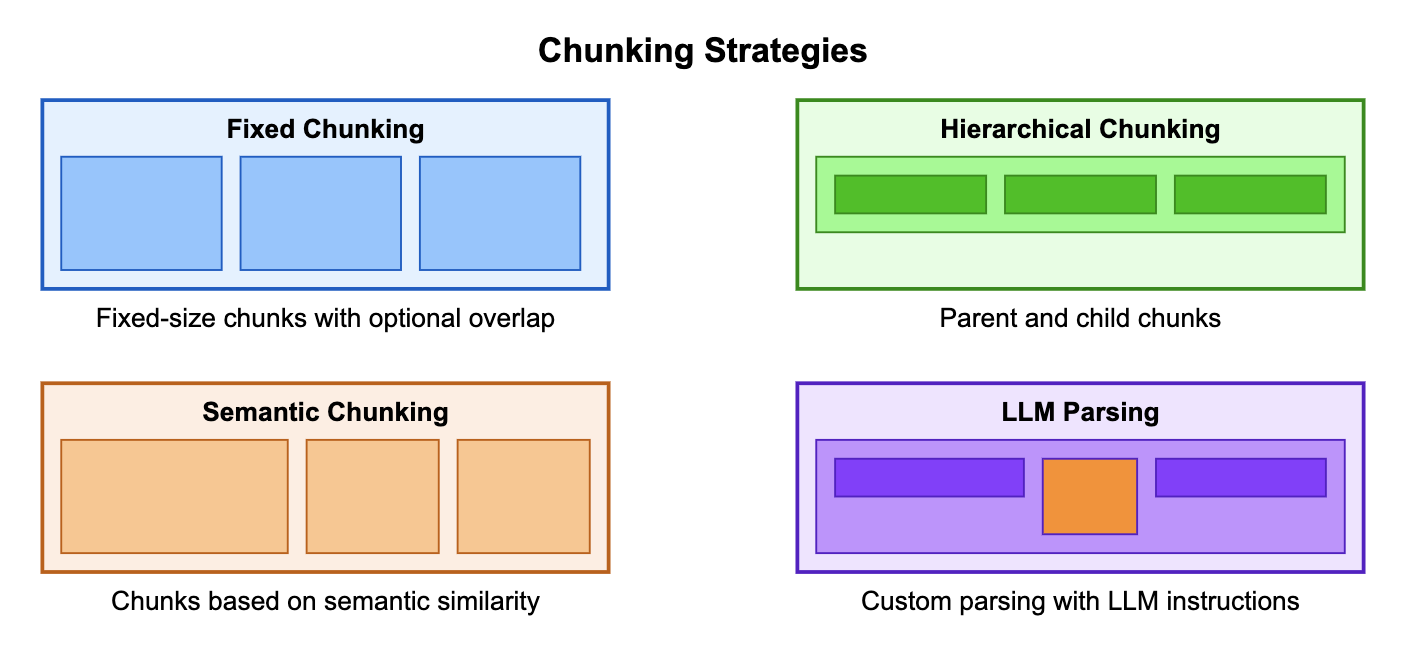

  **In this notebook we will look into standard/fixed chunking, Semantic Chunking and Hierarchical chunking.**





## Setup

Before running the rest of this notebook, you'll need to run the cells below to (ensure necessary libraries are installed and) connect to Bedrock.

In [27]:
%pip install -U opensearch-py==2.3.1 --quiet
%pip install -U boto3 --quiet
%pip install -U retrying==1.3.4 --quiet
%pip install --quiet langchain langchain-community langchain_experimental langchain_aws bs4 pypdf
%pip install --quiet llama-index

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-aws 0.1.16 requires boto3<1.35.0,>=1.34.131, but you have boto3 1.35.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Load Documents

We first need to download sample documents on which we will be building our Q&A. For this sample we are downloading Amazon letter to shareholders.

In [ ]:
!mkdir -p ./data

from urllib.request import urlretrieve

urls = [
    "https://s2.q4cdn.com/299287126/files/doc_financials/2023/ar/2022-Shareholder-Letter.pdf",
    "https://s2.q4cdn.com/299287126/files/doc_financials/2022/ar/2021-Shareholder-Letter.pdf",
    "https://s2.q4cdn.com/299287126/files/doc_financials/2021/ar/Amazon-2020-Shareholder-Letter-and-1997-Shareholder-Letter.pdf",
    "https://s2.q4cdn.com/299287126/files/doc_financials/2020/ar/2019-Shareholder-Letter.pdf",
]

filenames = [
    "AMZN-2022-Shareholder-Letter.pdf",
    "AMZN-2021-Shareholder-Letter.pdf",
    "AMZN-2020-Shareholder-Letter.pdf",
    "AMZN-2019-Shareholder-Letter.pdf",
]

data_root = "./data/"

for idx, url in enumerate(urls):
    file_path = data_root + filenames[idx]
    urlretrieve(url, file_path)

In [2]:
from langchain.document_loaders import PyPDFLoader
import os

data_root = "./data/"
folder_path = data_root
documents = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    loader = PyPDFLoader(file_path)
    # Load the PDF data
    data = loader.load()
    # Add the loaded data to the documents list
    documents.extend(data)

# Print the text of the first page of the first document
if documents:
    print(documents[0].page_content)
else:
    print("No PDF files found in the folder.")

To our shareowners:
In Amazon’s 1997 letter to shareholders, our first, I talked about our hope to create an “enduring franchise,”
one that would reinvent what it means to serve customers by unlocking the internet’s power. I noted that
Amazon had grown from having 158 employees to 614, and that we had surpassed 1.5 million customer
accounts. We had just gone public at a split-adjusted stock price of $1.50 per share. I wrote that it was Day 1.
We’ve come a long way since then, and we are working harder than ever to serve and delight customers.
Last year, we hired 500,000 employees and now directly employ 1.3 million people around the world. We have
more than 200 million Prime members worldwide. More than 1.9 million small and medium-sized businesses
sell in our store, and they make up close to 60% of our retail sales. Customers have connected more than
100 million smart home devices to Alexa. Amazon Web Services serves millions of customers and ended 2020
with a $50 billion annualized r

## Chunking

## 1. Fixed chunking

Fixed-size chunking allows you to customize the size of the text chunks by specifying the number of tokens per chunk and the amount of overlap between consecutive chunks. This provides flexibility to align the chunking with your specific requirements. You can set the maximum number of tokens that a chunk must not exceed, as well as the percentage of overlap between consecutive chunks. 

### 1.1 Character splitting

This is the simplest method. This splits text into chunks by specifying the number of tokens per chunk and an overlap percentage.

Let's load up LangChains `CharacterSplitter` and try it out!


In [1]:
from langchain.text_splitter import CharacterTextSplitter

This is the simplest method. This splits based on a given character sequence, which defaults to "\n\n". Chunk length is measured by number of characters.

1. How the text is split: by single character separator.
2. How the chunk size is measured: by number of characters.

In [7]:
text_splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=10, separator="")
splits = text_splitter.split_documents(documents)

`chunk_size`: the maximum length (in characters) of each chunk or segment that the text will be split into. 

`chunk_overlap`: the number of characters that should overlap between consecutive chunks. This overlap can help provide context to the subsequent chunks, especially when dealing with tasks that require understanding the surrounding context. 

`separator`: a string that specifies the separators used to split the text into chunks. By default, it is set to "\n\n", which means that the splitter will split the text at occurrences of two consecutive newline characters

In [8]:
splits[:2]

[Document(metadata={'source': './data/AMZN-2020-Shareholder-Letter.pdf', 'page': 0}, page_content='To our shareowners:\nIn Amazon’s 1997 letter to shareholders, our first, I talked about our hope to c'),
 Document(metadata={'source': './data/AMZN-2020-Shareholder-Letter.pdf', 'page': 0}, page_content='hope to create an “enduring franchise,”\none that would reinvent what it means to serve customers by')]

### 1.2 Recursive Character Text Splitting

With `CharacterTextSplitter` we simply split by a fix number of characters.

The Recursive Character Text Splitter is recommended for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.


In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

rec_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100, chunk_overlap=10
)
rec_text_splits = text_splitter.split_documents(documents)

In [11]:
rec_text_splits[:2]

[Document(metadata={'source': './data/AMZN-2020-Shareholder-Letter.pdf', 'page': 0}, page_content='To our shareowners:\nIn Amazon’s 1997 letter to shareholders, our first, I talked about our hope to c'),
 Document(metadata={'source': './data/AMZN-2020-Shareholder-Letter.pdf', 'page': 0}, page_content='hope to create an “enduring franchise,”\none that would reinvent what it means to serve customers by')]

## 2. Semantic Chunking

Semantic chunking is a natural language processing technique that divides text into meaningful and complete chunks based on the semantic similarity calculated by the embedding model. By focusing on the text's meaning and context, semantic chunking significantly improves the quality of retrieval in most use cases, rather than blind, syntactic chunking.


**Create Text Splitter**

To instantiate a `SemanticChunker`, we must specify an embedding model. Below we will use `BedrockEmbeddings`

In [18]:
from langchain_aws.embeddings.bedrock import BedrockEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")

embeddings_model = BedrockEmbeddings(
    client=bedrock_client, model_id="amazon.titan-embed-text-v1"
)

semantic_text_splitter = SemanticChunker(embeddings_model)

semantic_text_splits = semantic_text_splitter.split_documents(documents)

In [19]:
semantic_text_splits[:2]

[Document(metadata={'source': './data/AMZN-2020-Shareholder-Letter.pdf', 'page': 0}, page_content='To our shareowners:\nIn Amazon’s 1997 letter to shareholders, our first, I talked about our hope to create an “enduring franchise,”\none that would reinvent what it means to serve customers by unlocking the internet’s power. I noted that\nAmazon had grown from having 158 employees to 614, and that we had surpassed 1.5 million customer\naccounts. We had just gone public at a split-adjusted stock price of $1.50 per share. I wrote that it was Day 1. We’ve come a long way since then, and we are working harder than ever to serve and delight customers. Last year, we hired 500,000 employees and now directly employ 1.3 million people around the world. We have\nmore than 200 million Prime members worldwide. More than 1.9 million small and medium-sized businesses\nsell in our store, and they make up close to 60% of our retail sales. Customers have connected more than\n100 million smart home devices

**Breakpoints**

This chunker works by determining when to "break" apart sentences. This is done by looking for differences in embeddings between any two sentences. When that difference is past some threshold, then they are split.

There are a few ways to determine what that threshold is:
- Percentile
- Standard Deviation
- Interquartile
- Gradient


#### Percentile

The default way to split is based on percentile. In this method, all differences between sentences are calculated, and then any difference greater than the X percentile is split.

In [20]:
semantic_text_splitter = SemanticChunker(
    embeddings_model, breakpoint_threshold_type="percentile"
)

semantic_text_splits = semantic_text_splitter.split_documents(documents)

In [21]:
semantic_text_splits[:2]

[Document(metadata={'source': './data/AMZN-2020-Shareholder-Letter.pdf', 'page': 0}, page_content='To our shareowners:\nIn Amazon’s 1997 letter to shareholders, our first, I talked about our hope to create an “enduring franchise,”\none that would reinvent what it means to serve customers by unlocking the internet’s power. I noted that\nAmazon had grown from having 158 employees to 614, and that we had surpassed 1.5 million customer\naccounts. We had just gone public at a split-adjusted stock price of $1.50 per share. I wrote that it was Day 1. We’ve come a long way since then, and we are working harder than ever to serve and delight customers. Last year, we hired 500,000 employees and now directly employ 1.3 million people around the world. We have\nmore than 200 million Prime members worldwide. More than 1.9 million small and medium-sized businesses\nsell in our store, and they make up close to 60% of our retail sales. Customers have connected more than\n100 million smart home devices

**Standard Deviation**

In this method, any difference greater than X standard deviations is split.



In [22]:
semantic_text_splitter = SemanticChunker(
    embeddings_model, breakpoint_threshold_type="standard_deviation"
)

semantic_text_splits = semantic_text_splitter.split_documents(documents)

In [23]:
semantic_text_splits[:2]

[Document(metadata={'source': './data/AMZN-2020-Shareholder-Letter.pdf', 'page': 0}, page_content='To our shareowners:\nIn Amazon’s 1997 letter to shareholders, our first, I talked about our hope to create an “enduring franchise,”\none that would reinvent what it means to serve customers by unlocking the internet’s power. I noted that\nAmazon had grown from having 158 employees to 614, and that we had surpassed 1.5 million customer\naccounts. We had just gone public at a split-adjusted stock price of $1.50 per share. I wrote that it was Day 1. We’ve come a long way since then, and we are working harder than ever to serve and delight customers. Last year, we hired 500,000 employees and now directly employ 1.3 million people around the world. We have\nmore than 200 million Prime members worldwide. More than 1.9 million small and medium-sized businesses\nsell in our store, and they make up close to 60% of our retail sales. Customers have connected more than\n100 million smart home devices

**Interquartile**

In this method, the interquartile distance is used to split chunks.



In [24]:
semantic_text_splitter = SemanticChunker(
    embeddings_model, breakpoint_threshold_type="interquartile"
)

semantic_text_splits = semantic_text_splitter.split_documents(documents)

In [ ]:
semantic_text_splits[:2]

**Gradient**

In this method, the gradient of distance is used to split chunks along with the percentile method. This method is useful when chunks are highly correlated with each other or specific to a domain e.g. legal or medical. The idea is to apply anomaly detection on gradient array so that the distribution become wider and easy to identify boundaries in highly semantic data.



In [25]:
semantic_text_splitter = SemanticChunker(
    embeddings_model, breakpoint_threshold_type="gradient"
)

semantic_text_splits = semantic_text_splitter.split_documents(documents)

In [26]:
semantic_text_splits[:2]

[Document(metadata={'source': './data/AMZN-2020-Shareholder-Letter.pdf', 'page': 0}, page_content='To our shareowners:\nIn Amazon’s 1997 letter to shareholders, our first, I talked about our hope to create an “enduring franchise,”\none that would reinvent what it means to serve customers by unlocking the internet’s power.'),
 Document(metadata={'source': './data/AMZN-2020-Shareholder-Letter.pdf', 'page': 0}, page_content='I noted that\nAmazon had grown from having 158 employees to 614, and that we had surpassed 1.5 million customer\naccounts. We had just gone public at a split-adjusted stock price of $1.50 per share. I wrote that it was Day 1. We’ve come a long way since then, and we are working harder than ever to serve and delight customers. Last year, we hired 500,000 employees and now directly employ 1.3 million people around the world. We have\nmore than 200 million Prime members worldwide. More than 1.9 million small and medium-sized businesses\nsell in our store, and they make u

## 3. Hierarchical chunking

Hierarchical chunking goes a step further by organizing documents into parent and child chunks.

By structuring the document hierarchically, the model gains a better understanding of the relationships between different parts of the content, enabling it to provide more contextually relevant and coherent responses.

To implement this we are going to use `HierarchicalNodeParser` of `llama-index`.

This node parser will chunk nodes into hierarchical nodes. This means a single input will be chunked into several hierarchies of chunk sizes, with each node containing a reference to it's parent node.

When combined with the AutoMergingRetriever, this enables us to automatically replace retrieved nodes with their parents when a majority of children are retrieved. This process provides the LLM with more complete context for response synthesis.

In [29]:
from llama_index.core import SimpleDirectoryReader

reader = SimpleDirectoryReader(input_dir="data")
documents = reader.load_data()

In [30]:
from llama_index.core.node_parser import HierarchicalNodeParser

node_parser = HierarchicalNodeParser.from_defaults(chunk_sizes=[512, 254, 128])

nodes = node_parser.get_nodes_from_documents(documents)
nodes[0].text

'To our shareowners:\nOne thing we’ve learned from the COVID-19 crisis is how important Amazon has become to our customers. We\nwant you to know we take this responsibility seriously, and we’re proud of the work our teams are doing to helpcustomers through this difficult time.\nAmazonians are working around the clock to get necessary supplies delivered directly to the doorsteps of people\nwho need them. The demand we are seeing for essential products has been and remains high. But unlike apredictable holiday surge, this spike occurred with little warning, creating major challenges for our suppliers anddelivery network. We quickly prioritized the stocking and delivery of essential household staples, medicalsupplies, and other critical products.\nOur Whole Foods Market stores have remained open, providing fresh food and other vital goods for customers.\nWe are taking steps to help those most vulnerable to the virus, setting aside the first hour of shopping at WholeFoods each day for seni

In [31]:
nodes[1].text

'We’ve shifted training protocols so we don’thave employees gathering in one spot, and we’ve adjusted our hiring processes to allow for social distancing.\nA next step in protecting our employees might be regular testing of all Amazonians, including those showing no\nsymptoms. Regular testing on a global scale, across all industries, would both help keep people safe and help getthe economy back up and running. For this to work, we as a society would need vastly more testing capacity thanis currently available. If every person could be tested regularly, it would make a huge difference in how we fightthis virus. Those who test positive could be quarantined and cared for, and everyone who tests negative couldre-enter the economy with confidence.\nWe’ve begun the work of building incremental testing capacity. A team of Amazonians—from research scientists\nand program managers to procurement specialists and software engineers—moved from their normal day jobsonto a dedicated team to work on 

## Conclusion

In this notebook we have seen standard chunking with Character Splitting and Recursive Character Text Splitting. If you are working with standard text documents you can start with these two approaches to get started. We have also seen Semantic chunking which is a more advanced approach that uses semantic similarity instead of fixed chunk sizes.

## Next steps:

- Explore advance parsing options for complex data such as tables and graphs using Amazon Bedrock Knowledge bases - https://docs.aws.amazon.com/bedrock/latest/userguide/kb-chunking-parsing.html
- Explore evaluating the performance of different chunking strategies 
- Try out these strategies with Amazon Bedrock knowledge base 